In [103]:
#######################

In [1]:


nuwro = True
ISRUN3 = False


isTruth = False


In [2]:
import sys

#sys.path.insert(0, 'backend_functions')

#import selection_functions as sf

import importlib

import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb

import awkward
import matplotlib.pyplot as plt
import pandas as pd

import ROOT
from ROOT import TH1F, TH2F, TDirectory, TH1D

#import top 
#from top import *

#importlib.reload(sf)
#from selection_functions import *

Welcome to JupyROOT 6.24/02


In [3]:


fold = "nuselection"
tree = "NeutrinoSelectionFilter"



In [4]:
if nuwro: 
    path = "/media/alex/TOSHIBA EXT/"

In [5]:


if nuwro: 
    overlay = uproot.open(path+"neutrinoselection_filt_run1_overlay_nuwro.root")[fold][tree]
    nue = uproot.open(path+"neutrinoselection_filt_run1_overlay_nuwro_intrinsic.root")[fold][tree]

uproot_v = [overlay,nue]

In [6]:


variables = [
    "selected", "nu_pdg", 
    "trk_score_v", 
    "shr_tkfit_dedx_Y",
    "ccnc", "shr_px", "shr_py", "shr_pz",
    "n_tracks_contained", 
    "NeutrinoEnergy2", "shr_theta", "shr_phi",
    "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
    "true_nu_vtx_x", "true_nu_vtx_y" , "true_nu_vtx_z", 
    "nproton", "nu_e", "n_showers_contained",
    "shr_score", 
    "trk_energy", "tksh_distance", "tksh_angle",
    "npi0", "trk_energy_tot",
    "shr_energy_tot_cali", "shr_energy_cali", 
    "nslice", "true_nu_vtx_sce_x", "true_nu_vtx_sce_y", "true_nu_vtx_sce_z",
    "contained_fraction",
    "npion", 
    "shrmoliereavg", 
    "shrsubclusters0","shrsubclusters1","shrsubclusters2", 
    "shr_tkfit_npointsvalid","shr_tkfit_npoints", "true_e_visible", "trkshrhitdist2", 
    "weightSplineTimesTune", "weightTune", "true_nu_px", "true_nu_py", "true_nu_pz", 
    "elec_e", "proton_e", "mc_px", "mc_py", "mc_pz", "elec_px", "elec_py", "elec_pz", 
    "swtrig_pre", "ppfx_cv", "mc_pdg",  'interaction', 'run', "opening_angle", "mc_E"]



In [7]:


overlay = overlay.pandas.df(variables, flatten=False)



In [8]:


nue = nue.pandas.df(variables, flatten=False)



In [9]:
df_v = [overlay,nue]


In [10]:


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_llr_pid_v = up.array('trk_llr_pid_score_v')
    trk_id = up.array('trk_id')-1 # I think we need this -1 to get the right result
    trk_llr_pid_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    df['trkpid'] = trk_llr_pid_v_sel
    df['subcluster'] = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']

    df['NeutrinoEnergy2_GeV'] = df['NeutrinoEnergy2']/1000



In [11]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [12]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [13]:
##Calculate the total KE of all protons
#proton_e is only that of the highest energy proton

#s = time.time()

Mp = 0.938272046

for entry in df_v:
    # Each of the things here is a column of arrays
    # First, set everywhere that is 2212 = True and False otherwise
    mask_2 = entry["mc_pdg"].apply(lambda x: np.array(2212 == x))
    # Now find which entries contain a 2212 value
    mask_1 = mask_2.apply(lambda x: np.any(x))
    # Next do the maths to the entries (we'll mask out unwanted bits later)
    mask_3 = entry["mc_E"].apply(lambda x: np.array(x > (0.04 + Mp)))
    # As the contents of mask_2 and mask_3 are arrays, this * operation
    # will multiply every element of mask_2 by every element of mask_3
    # Essentially performing an elementwise AND on every element
    mask_4 = mask_2 * mask_3
    # Default value => 0 where no mask is true
    entry["proton_total_KE"] = np.zeros_like(entry["proton_e"].values)
    # Finally for every place mask_4 applies, we want the mc_E value less Mp summed
    nums = (((entry.loc[:, "mc_E"] - Mp) * mask_4)).apply(lambda x: np.sum(x))
    # And finally, plonk this value into the dataframe
    entry.loc[mask_1, "proton_total_KE"] = nums[mask_1]

    
#just prints out the time this cell takes
#s2 = time.time()
#print ("time to run: ",s2-s)

In [14]:
INTERCEPT = 0.0
SLOPE = 0.83

# define some energy-related variables
for i,df in enumerate(df_v):
    print(df["proton_total_KE"])
    df["reco_e"] = (df["shr_energy_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
    df["true_e"] = df["elec_e"] + df["proton_total_KE"]

entry
0         0.118131
1         0.000000
2         0.081623
3         0.000000
4         0.000000
            ...   
280040    0.000000
280041    0.785977
280042    0.307544
280043    0.000000
280044    0.000000
Name: proton_total_KE, Length: 280045, dtype: float32
entry
0         0.141086
1         0.000000
2         0.104487
3         0.399496
4         0.086794
            ...   
132022    0.000000
132023    0.064317
132024    0.061194
132025    0.000000
132026    0.000000
Name: proton_total_KE, Length: 132027, dtype: float32


In [15]:
######################### plot categories ##############################
# everything must pass software trigger ! 

in_fv_query = "10<=true_nu_vtx_x<=246 and -106<=true_nu_vtx_y<=106 and 10<=true_nu_vtx_z<=1026"
out_fv_query = "((true_nu_vtx_x<10 or true_nu_vtx_x>246) or (true_nu_vtx_y<-106 or true_nu_vtx_y>106) or (true_nu_vtx_z<10 or true_nu_vtx_z>1026))"

numu_CC_Npi0 = 'swtrig_pre==1 and ((nu_pdg==14 or nu_pdg==-14) and ccnc==0 and npi0>=1)'
numu_CC_0pi0 = 'swtrig_pre==1 and ((nu_pdg==14 or nu_pdg==-14) and ccnc==0 and npi0==0)'

numu_NC_Npi0 = 'swtrig_pre==1 and ((nu_pdg==14 or nu_pdg==-14) and ccnc==1 and npi0>=1)'
numu_NC_0pi0 = 'swtrig_pre==1 and ((nu_pdg==14 or nu_pdg==-14) and ccnc==1 and npi0==0)'

nuebar_1eNp = 'swtrig_pre==1 and ((nu_pdg==-12 and ccnc==0 and nproton>0 and npion==0 and npi0==0))'
nue_NC = 'swtrig_pre==1 and ((nu_pdg==12 or nu_pdg==-12) and ccnc==1)'

nue_CCother = 'swtrig_pre==1 and (((nu_pdg==12 and ccnc==0) and (nproton==0 or npi0>0 or npion>0)) or (nu_pdg==-12 and ccnc==0 and (nproton==0 or npion>0 or npi0>0)))'

# less specific categories 
nue_other = 'swtrig_pre==1 and (((nu_pdg==12 or nu_pdg==-12) and ccnc==1) or (((nu_pdg==12 and ccnc==0) and (nproton==0 or npi0>0 or npion>0)) or (nu_pdg==-12 and ccnc==0)))'
numu_Npi0 = 'swtrig_pre==1 and ( (nu_pdg==14 or nu_pdg==-14) and npi0>=1)'
numu_0pi0 = 'swtrig_pre==1 and ( (nu_pdg==14 or nu_pdg==-14) and npi0==0)'

# signal vs. not signal 
signal = in_fv_query+' and  swtrig_pre==1 and (nu_pdg==12 and ccnc==0 and nproton>0 and npion==0 and npi0==0)'
not_signal = "(swtrig_pre==0) or (swtrig_pre==1 and (" + out_fv_query+' or (nu_pdg!=12) or (nu_pdg==12 and ccnc==1) or (nu_pdg==12 and ccnc==0 and (nproton==0 or npi0>0 or npion>0))))'

# for replacing nue CC 
in_AV_query = "-1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8"
nueCC_query = 'abs(nu_pdg)==12 and ccnc==0 and '+in_AV_query

In [16]:
overlay = overlay.query('swtrig_pre==1')
nue = nue.query('swtrig_pre==1')

In [17]:
mc_df = [overlay, nue]

In [18]:
def addAngles(df): #From Katrina
    
    ## rotation matrix -- convert detector to beam coordinates
    R = [
        [0.921,   4.625e-05,     -0.3895],
        [0.02271,    0.9983,     0.05383],
        [0.3888,   -0.05843,      0.9195]
    ]
    det_origin_beamcoor = [5502.0, 7259.0,  67270.0]
     
    # angles in detector coordinates
    df['thdet'] = np.arctan2(((df['true_nu_px']*df['true_nu_px'])+(df['true_nu_py']*df['true_nu_py']))**(1/2), df['true_nu_pz'])*(180/math.pi)
    df['phidet'] = np.arctan2(df['true_nu_py'], df['true_nu_px'])*(180/math.pi)
        
    # get true momentum in beam coordinates
    df['true_nu_px_beam'] = R[0][0]*df['true_nu_px'] + R[0][1]*df['true_nu_py'] + R[0][2]*df['true_nu_pz']
    df['true_nu_py_beam'] = R[1][0]*df['true_nu_px'] + R[1][1]*df['true_nu_py'] + R[1][2]*df['true_nu_pz']
    df['true_nu_pz_beam'] = R[2][0]*df['true_nu_px'] + R[2][1]*df['true_nu_py'] + R[2][2]*df['true_nu_pz']
    
    # angles in beam coordinates
    df['thbeam'] = np.arctan2(((df['true_nu_px_beam']*df['true_nu_px_beam'])+(df['true_nu_py_beam']*df['true_nu_py_beam']))**(1/2), df['true_nu_pz_beam'])*(180/math.pi)
    df['phibeam'] = np.arctan2(df['true_nu_py_beam'], df['true_nu_px_beam'])*(180/math.pi)
        
    return df

In [19]:
# use offline flux weights
def offline_flux_weights(df, ISRUN3): 
    
    if ISRUN3: 
        print("No ppfx maps for RHC!")
    
    else: 
        f = ROOT.TFile.Open(path+"ppfx_maps.root", "READ")
    
    numu_map = f.Get("numu_ratio")
    numubar_map = f.Get("numubar_ratio")
    nue_map = f.Get("nue_ratio")
    nuebar_map = f.Get("nuebar_ratio")
    
    nu_flav = list(df['nu_pdg'])
    angle = list(df['thbeam'])
    true_energy = list(df['nu_e'])

    fluxweights = []

    for i in range(len(nu_flav)): 
        if nu_flav[i]==14: 
            h = numu_map
        elif nu_flav[i]==-14: 
            h = numubar_map
        elif nu_flav[i]==12: 
            h = nue_map
        elif nu_flav[i]==-12: 
            h = nuebar_map
        else: 
            print("No map to match PDG code!")
        
        fluxweights.append( h.GetBinContent(h.FindBin(true_energy[i], angle[i])) )

    df['ppfx_cv'] = fluxweights
    #mc_df[0]['weightFlux'] = fluxweights
    #mc_df[1]['weightFlux'] = [1 for i in range(len(mc_df[1]))] # for now 
    
    f.Close()
    
    return df

In [20]:


for i,df in enumerate(mc_df):
    
    # is signal bool 
    df['is_signal'] = np.where((df.swtrig_pre == 1)
                             & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                             & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                             & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                             & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    
    # Add truth level theta & phi angles (detector & beam coordinates)
    df = addAngles(df)
    
    # add binned ppfx weights
    if nuwro: 
        df = offline_flux_weights(df, ISRUN3)
    



/tmp/ipykernel_6168/3879574672.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_signal'] = np.where((df.swtrig_pre == 1)
/tmp/ipykernel_6168/3654421403.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['thdet'] = np.arctan2(((df['true_nu_px']*df['true_nu_px'])+(df['true_nu_py']*df['true_nu_py']))**(1/2), df['true_nu_pz'])*(180/math.pi)
/tmp/ipykernel_6168/3654421403.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [21]:
print(len(nue.query('is_signal==True'))==len(nue.query(signal)))
print(len(nue.query('is_signal==False'))==len(nue.query(not_signal)))

True
True


In [22]:


# clean bad weights & values 

for i,df in enumerate(mc_df):
     
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1.
    
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.  

     



/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [23]:
###SCALRE BY POT INSTEAD!

"""
# scale down the number of events to match data POT 

nue = nue[:round(len(nue)*0.0119)]   #1519
overlay = overlay[:round(len(overlay)*0.301)]  #67370
#print(len(nue))

#print(len(nue[:round(len(nue)*0.0119)]))
#print(len(overlay[:round(len(overlay)*0.301)]))

#nue = nue[round(len(nue)*0.0119):round((len(nue)*0.0119)*2) ]   #1519
#overlay = overlay[round(len(overlay)*0.301):round((len(overlay)*0.301)*2)]  #67370

print((len(nue)))
"""

'\n# scale down the number of events to match data POT \n\nnue = nue[:round(len(nue)*0.0119)]   #1519\noverlay = overlay[:round(len(overlay)*0.301)]  #67370\n#print(len(nue))\n\n#print(len(nue[:round(len(nue)*0.0119)]))\n#print(len(overlay[:round(len(overlay)*0.301)]))\n\n#nue = nue[round(len(nue)*0.0119):round((len(nue)*0.0119)*2) ]   #1519\n#overlay = overlay[round(len(overlay)*0.301):round((len(overlay)*0.301)*2)]  #67370\n\nprint((len(nue)))\n'

In [24]:


# POT normalization - scale to data 

if ISRUN3: 
    data_pot = 5.0E20
else: 
    data_pot = 2.0E20

if nuwro==True: 
    overlay['pot_scale'] = data_pot/6.64422e+20
    nue['pot_scale'] = data_pot/1.68375e+22

else: 
    overlay = pot_scale(overlay, 'overlay', ISRUN3)
    nue = pot_scale(nue, 'intrinsic', ISRUN3)
    
    #overlay['pot_scale'] = data_pot/2.33652e+21
    #nue['pot_scale'] = data_pot/2.37838e+22



/tmp/ipykernel_6168/542743503.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overlay['pot_scale'] = data_pot/6.64422e+20
/tmp/ipykernel_6168/542743503.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nue['pot_scale'] = data_pot/1.68375e+22


In [25]:
if nuwro == True: 

    overlay['totweight_data'] = overlay['pot_scale']*overlay['ppfx_cv']
    nue['totweight_data'] = nue['pot_scale']*nue['ppfx_cv']

else: 
    
    overlay['totweight_data'] = overlay['pot_scale']*overlay['ppfx_cv']*overlay['weightSplineTimesTune']
    nue['totweight_data'] = nue['pot_scale']*nue['ppfx_cv']*nue['weightSplineTimesTune']



/tmp/ipykernel_6168/593504767.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overlay['totweight_data'] = overlay['pot_scale']*overlay['ppfx_cv']
/tmp/ipykernel_6168/593504767.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nue['totweight_data'] = nue['pot_scale']*nue['ppfx_cv']


In [26]:
#########################
#RUN ONLY ONCE#######
###################

print("# of nueCC in AV in overlay sample = "+str(len(overlay.query(nueCC_query))))
len1 = len(overlay)
    
idx = overlay.query(nueCC_query).index
overlay.drop(idx, inplace=True)
len2 = len(overlay) 
print("# of nueCC in AV dropped in overlay = "+str(len1-len2))
    
# then add in nue_intrinsic 
overlay = pd.concat([overlay,nue], ignore_index=True)

# from here on out everything else should be the same. 

# of nueCC in AV in overlay sample = 3830
# of nueCC in AV dropped in overlay = 3830


/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [27]:


# separate by in/out FV & cosmic
infv = overlay.query(in_fv_query)
outfv = overlay.query(out_fv_query)



In [28]:
# check that everything is accounted for 
print(len(overlay)==len(infv)+len(outfv))

True


In [29]:


tot_signal_weighted = np.nansum(infv.query('is_signal==True')['pot_scale'])
print('total signal events = '+ str(tot_signal_weighted))





tot_signal_weighted = np.nansum(outfv.query('is_signal==True')["nslice"])
print('total signal events = '+ str(tot_signal_weighted))

total signal events = 429.7431328878989
total signal events = 0


In [30]:
datasets = {
    'infv' : infv, 
    'outfv' : outfv
}

In [31]:


generated_events = pd.concat([datasets['outfv'], datasets['infv']])



In [32]:
tot_signal_weighted = np.nansum(generated_events.query('is_signal==True')['pot_scale'])
print('total signal events = '+ str(tot_signal_weighted))

tot_signal_weighted = np.nansum(generated_events.query('is_signal==False')['pot_scale'])
print('total signal events = '+ str(tot_signal_weighted))


tot_signal_weighted = np.nansum(generated_events.query('is_signal==True')['totweight_data'])
print('total signal events = '+ str(tot_signal_weighted))

tot_signal_weighted = np.nansum(generated_events.query(signal)['totweight_data'])
print('total signal events = '+ str(tot_signal_weighted))

total signal events = 429.7431328878989
total signal events = 67306.18869786244
total signal events = 387.74397309124674
total signal events = 387.74397309124674


In [33]:
isTruth

False

In [34]:
if isTruth == False:
    reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"


    BDT_PRE_QUERY = 'swtrig_pre==1 and nslice==1'
    BDT_PRE_QUERY += ' and ' + reco_in_fv_query
    BDT_PRE_QUERY +=' and contained_fraction>0.9'
    BDT_PRE_QUERY += ' and n_showers_contained==1'
    BDT_PRE_QUERY += ' and n_tracks_contained>0'
    BDT_PRE_QUERY += ' and trk_energy>0.04' 

    BDT_LOOSE_CUTS = BDT_PRE_QUERY
    BDT_LOOSE_CUTS +=' and shr_score<0.3'
    BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
    BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
    BDT_LOOSE_CUTS += ' and trkpid<0.35'
    BDT_LOOSE_CUTS += ' and tksh_distance<12'
elif isTruth == True:
    selected_query = "is_signal == True"

In [35]:
if isTruth == False:
    datasets_bdt = {}

    bdt_score_cut = 0.55
    selected_query = BDT_LOOSE_CUTS +' and BDT_score>'+str(bdt_score_cut)

    #selected_query = "is_signal==True"
    #print("BDT SCORE THRESHOLD = "+str(bdt_score_cut))

    print(selected_query)

swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and BDT_score>0.55


In [35]:
if isTruth == True:
    datasets_bdt = {}


    for i in range(len(datasets)): 

        df = list(datasets.values())[i].copy()
        
        #ENERGY
        tmp = df["reco_e"].copy()
        mask = (df["reco_e"] > 3)
        tmp[mask] = 2.75
        df["reco_e"] = tmp
        print(df["reco_e"])
        #------
        tmp = df["reco_e"].copy()
        mask = (df["reco_e"] < 0)
        tmp[mask] = 0.25
        df["reco_e"] = tmp
        print(df["reco_e"])
        #####

        #ENERGY
        tmp = df["true_e"].copy()
        mask = (df["true_e"] > 3)
        tmp[mask] = 2.75
        df["true_e"] = tmp
        print(df["true_e"])
        #------
        tmp = df["true_e"].copy()
        mask = (df["true_e"] < 0)
        tmp[mask] = 0.25
        df["true_e"] = tmp
        print(df["true_e"])

        datasets_bdt[list(datasets.keys())[i]] = df.query(selected_query)

print(selected_query)

1         0.064217
3         0.000000
7         0.000000
11        0.153571
13        0.225464
            ...   
347635    1.163621
347636    0.062386
347637    0.000000
347638    1.460207
347639    2.338106
Name: reco_e, Length: 198334, dtype: float32
1         0.064217
3         0.000000
7         0.000000
11        0.153571
13        0.225464
            ...   
347635    1.163621
347636    0.062386
347637    0.000000
347638    1.460207
347639    2.338106
Name: reco_e, Length: 198334, dtype: float32
1         0.081623
3         0.080866
7         0.100546
11        0.150946
13        0.065419
            ...   
347635    1.263070
347636    1.163127
347637    0.061194
347638    1.544370
347639    1.958760
Name: true_e, Length: 198334, dtype: float32
1         0.081623
3         0.080866
7         0.100546
11        0.150946
13        0.065419
            ...   
347635    1.263070
347636    1.163127
347637    0.061194
347638    1.544370
347639    1.958760
Name: true_e, Length: 198334,

In [36]:
#this box makes the selection for selected events if used

if isTruth == False:
    # load bdt model 
    split = 1
    # load bdt model 
    bdt_model = xgb.Booster({'nthread': 4})
    bdt_model.load_model('/home/alex/NuMI/bdt_FHC_may2022_subset.model')

    for i in range(len(datasets)): 

        training_parameters = [
        "shr_score", "shrmoliereavg", "trkpid",
        "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
        "tksh_angle", "subcluster", "trkshrhitdist2"]

        df = list(datasets.values())[i].copy()
        df = df.query(BDT_LOOSE_CUTS)
        
        #ENERGY
        tmp = df["reco_e"].copy()
        mask = (df["reco_e"] > 3)
        tmp[mask] = 2.75
        df["reco_e"] = tmp
        print(df["reco_e"])
        #------
        tmp = df["reco_e"].copy()
        mask = (df["reco_e"] < 0)
        tmp[mask] = 0.25
        df["reco_e"] = tmp
        print(df["reco_e"])
        #####

        #ENERGY
        tmp = df["true_e"].copy()
        mask = (df["true_e"] > 3)
        tmp[mask] = 2.75
        df["true_e"] = tmp
        print(df["true_e"])
        #------
        tmp = df["true_e"].copy()
        mask = (df["true_e"] < 0)
        tmp[mask] = 0.25
        df["true_e"] = tmp
        print(df["true_e"])
        

        # clean datasets 
        for column in training_parameters:
            df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan

        # create testing dmatrix 
        df_test = xgb.DMatrix(data=df[training_parameters])

        # apply the bdt selection
        preds = bdt_model.predict(df_test)

        # add columns for plotting 
        df['BDT_score'] = preds

        datasets_bdt[list(datasets.keys())[i]] = df.query(selected_query)

502       1.398879
701       0.236469
879       0.101979
1003      0.578445
1227      0.464323
            ...   
347587    0.324122
347604    0.644731
347609    0.430854
347617    0.982283
347632    0.730223
Name: reco_e, Length: 11423, dtype: float32
502       1.398879
701       0.236469
879       0.101979
1003      0.578445
1227      0.464323
            ...   
347587    0.324122
347604    0.644731
347609    0.430854
347617    0.982283
347632    0.730223
Name: reco_e, Length: 11423, dtype: float32
502       0.395897
701       0.000000
879       0.169964
1003      0.418483
1227      0.370149
            ...   
347587    0.354568
347604    0.679704
347609    0.871486
347617    0.989657
347632    0.810929
Name: true_e, Length: 11423, dtype: float32
502       0.395897
701       0.000000
879       0.169964
1003      0.418483
1227      0.370149
            ...   
347587    0.354568
347604    0.679704
347609    0.871486
347617    0.989657
347632    0.810929
Name: true_e, Length: 11423, dty

In [37]:
xvar = 'reco_e'
true_var = 'true_e'
bins = np.arange(0, 3.5, 0.5)

xlow = bins[0]
xhigh = bins[-1]

x_label = "Neutrino Energy"
x_ticks = np.arange(0, 3.5, 0.5)

In [38]:


if xvar=='tksh_angle': 
    bincenters = 0.5*(np.array(x_ticks)[1:]+np.array(x_ticks)[:-1])

else: 
    #bincenters = 0.5*(np.array(x_ticks+[xhigh])[1:]+np.array(x_ticks+[xhigh])[:-1])
    bincenters = np.arange(0.25, 3.25, 0.5)



In [39]:
labels = { 
    'signal' : ['$\\nu_e$ CC0$\pi$Np', 'orange'], 
    'numu_CC_Npi0' : ['$\\nu_\mu$ CC $\pi^{0}$', 'brown'],
    'numu_NC_Npi0' : ['$\\nu_\mu$ NC $\pi^{0}$', 'orangered'],
    'numu_NC_0pi0' : ['$\\nu_\mu$ NC', '#33FCFF'],
    'numu_CC_0pi0' : ['$\\nu_\mu$ CC', '#437ED8'],
    'nue_CCother': ['$\\nu_e$ CC other', '#05B415'], 
    'nue_NC': ['$\\nu_e$ NC', '#B8FF33'], 
    'outfv' : ['Out FV', 'orchid'], 
    'ext' : ['EXT', 'lightpink'],
    'nue_other' : ['$\\nu_e$ / $\\overline{\\nu_e}$  other', '#33db09'], 
    'numu_Npi0' : ['$\\nu_\\mu$ / $\\overline{\\nu_\\mu}$  $\pi^{0}$', '#EE1B1B'], 
    'numu_0pi0' : ['$\\nu_\\mu$ / $\\overline{\\nu_\\mu}$  other', '#437ED8'],
    'nuebar_1eNp' : ['$\\bar{\\nu}_e$ CC0$\pi$Np', 'gold']
}

In [40]:
leg = {
        'outfv' : labels['outfv'][0]+': ' + str( round(sum(datasets_bdt['outfv'].totweight_data), 1)) , 
        'numu_NC_Npi0' : labels['numu_NC_Npi0'][0]+': '+ str( round(sum(datasets_bdt['infv'].query(numu_NC_Npi0).totweight_data), 1)), 
        'numu_CC_Npi0' : labels['numu_CC_Npi0'][0]+': '+str( round(sum(datasets_bdt['infv'].query(numu_CC_Npi0).totweight_data), 1)), 
        'numu_NC_0pi0' : labels['numu_NC_0pi0'][0]+': '+str( round(sum(datasets_bdt['infv'].query(numu_NC_0pi0).totweight_data), 1)), 
        'numu_CC_0pi0' : labels['numu_CC_0pi0'][0]+': '+str( round(sum(datasets_bdt['infv'].query(numu_CC_0pi0).totweight_data), 1)), 
        'nue_NC' : labels['nue_NC'][0]+': '+str( round(sum(datasets_bdt['infv'].query(nue_NC).totweight_data), 1)), 
        'nue_CCother' : labels['nue_CCother'][0]+': '+str( round(sum(datasets_bdt['infv'].query(nue_CCother).totweight_data), 1)),
        'nuebar_1eNp' : labels['nuebar_1eNp'][0]+': '+str( round(sum(datasets_bdt['infv'].query(nuebar_1eNp).totweight_data), 1)), 
        'signal' : labels['signal'][0]+': '+str( round(sum(datasets_bdt['infv'].query(signal).totweight_data), 1))
    }


/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


220007    1.311443
220037    1.034346
220041    1.980417
220067    1.083881
220092    0.338537
            ...   
347480    0.917483
347556    1.142170
347573    0.983597
347587    0.324122
347604    0.644731
Name: reco_e, Length: 4648, dtype: float32
[13.27200403 37.07373718 14.05394212  4.82427243  1.44403517  0.98508674]
71.65307766959825


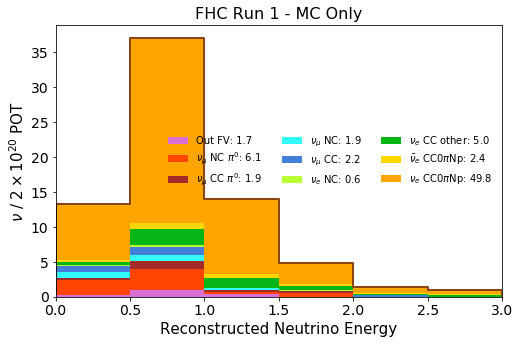

In [41]:
if isTruth == False:
    fig = plt.figure(figsize=(8, 5))


    n, b, p = plt.hist([datasets_bdt['outfv'][xvar], 
                           datasets_bdt['infv'].query(numu_NC_Npi0)[xvar],
                           datasets_bdt['infv'].query(numu_CC_Npi0)[xvar],
                           datasets_bdt['infv'].query(numu_NC_0pi0)[xvar],
                           datasets_bdt['infv'].query(numu_CC_0pi0)[xvar],
                           datasets_bdt['infv'].query(nue_NC)[xvar],
                           datasets_bdt['infv'].query(nue_CCother)[xvar],
                           datasets_bdt['infv'].query(nuebar_1eNp)[xvar], 
                           datasets_bdt['infv'].query(signal)[xvar]],
                bins, histtype='bar', range=[xlow, xhigh], stacked=True, 
                color=[labels['outfv'][1], 
                           labels['numu_NC_Npi0'][1], 
                           labels['numu_CC_Npi0'][1], 
                           labels['numu_NC_0pi0'][1], 
                           labels['numu_CC_0pi0'][1], 
                           labels['nue_NC'][1], 
                           labels['nue_CCother'][1],
                           labels['nuebar_1eNp'][1], 
                           labels['signal'][1]], 
                label=[leg['outfv'], 
                       leg['numu_NC_Npi0'], 
                       leg['numu_CC_Npi0'], 
                       leg['numu_NC_0pi0'], 
                       leg['numu_CC_0pi0'], 
                       leg['nue_NC'], 
                       leg['nue_CCother'], 
                       leg['nuebar_1eNp'], 
                       leg['signal']
                      ],
                weights=[datasets_bdt['outfv'].totweight_data, 
                         datasets_bdt['infv'].query(numu_NC_Npi0).totweight_data, 
                         datasets_bdt['infv'].query(numu_CC_Npi0).totweight_data,
                         datasets_bdt['infv'].query(numu_NC_0pi0).totweight_data,
                         datasets_bdt['infv'].query(numu_CC_0pi0).totweight_data,
                         datasets_bdt['infv'].query(nue_NC).totweight_data,
                         datasets_bdt['infv'].query(nue_CCother).totweight_data,
                         datasets_bdt['infv'].query(nuebar_1eNp).totweight_data,
                         datasets_bdt['infv'].query(signal).totweight_data 
                         ])

    print(datasets_bdt['infv'].query(signal)[xvar])
    
    #print(n)
    #print("sum in each bin is ", sum(n))
    print(n[-1])
    print(sum(n[-1]))
    #print(sum(sum(n)))


    nuWro_selected_events_nue = n[-1]

    # simulation outline 
    tot = list([0, n[-1][0]])+list(n[-1])+[0]
    b_step = list([b[0]])+list(b)+list([b[-1]])
    plt.step(b_step, tot, color='saddlebrown', linewidth=2)

    # plot format stuff
    plt.legend(loc='best', prop={"size":10}, ncol=3, frameon=False)



    plt.xlabel("Reconstructed "+x_label, fontsize=15)

    #plt.xticks(x_ticks, fontsize=14)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.xlim(xlow, xhigh)
    #plt.ylim(0, 30)

    if not ISRUN3: 
        plt.title("FHC Run 1 - MC Only", fontsize=16)
        plt.ylabel('$\\nu$ / $2\\times10^{20}$ POT', fontsize=15)
    else: 
        plt.title("RHC Run 3 - MC Only", fontsize=16)
        plt.ylabel('$\\nu$ / $5\\times10^{20}$ POT', fontsize=15)


    plt.show()


/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


[ 62.29377134 170.14500672  92.21299166  34.17399711  13.33827119
  15.57993508]
387.7439730913552
use truth =  True


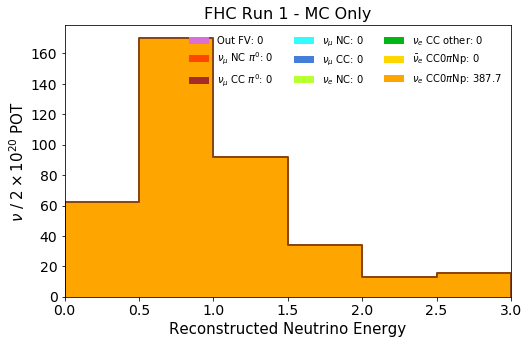

In [40]:
if isTruth == True:
    fig = plt.figure(figsize=(8, 5))


    n, b, p = plt.hist([datasets_bdt['outfv'][true_var], 
                           datasets_bdt['infv'].query(numu_NC_Npi0)[true_var],
                           datasets_bdt['infv'].query(numu_CC_Npi0)[true_var],
                           datasets_bdt['infv'].query(numu_NC_0pi0)[true_var],
                           datasets_bdt['infv'].query(numu_CC_0pi0)[true_var],
                           datasets_bdt['infv'].query(nue_NC)[true_var],
                           datasets_bdt['infv'].query(nue_CCother)[true_var],
                           datasets_bdt['infv'].query(nuebar_1eNp)[true_var], 
                           datasets_bdt['infv'].query(signal)[true_var]],
                bins, histtype='bar', range=[xlow, xhigh], stacked=True, 
                color=[labels['outfv'][1], 
                           labels['numu_NC_Npi0'][1], 
                           labels['numu_CC_Npi0'][1], 
                           labels['numu_NC_0pi0'][1], 
                           labels['numu_CC_0pi0'][1], 
                           labels['nue_NC'][1], 
                           labels['nue_CCother'][1],
                           labels['nuebar_1eNp'][1], 
                           labels['signal'][1]], 
                label=[leg['outfv'], 
                       leg['numu_NC_Npi0'], 
                       leg['numu_CC_Npi0'], 
                       leg['numu_NC_0pi0'], 
                       leg['numu_CC_0pi0'], 
                       leg['nue_NC'], 
                       leg['nue_CCother'], 
                       leg['nuebar_1eNp'], 
                       leg['signal']
                      ],
                weights=[datasets_bdt['outfv'].totweight_data, 
                         datasets_bdt['infv'].query(numu_NC_Npi0).totweight_data, 
                         datasets_bdt['infv'].query(numu_CC_Npi0).totweight_data,
                         datasets_bdt['infv'].query(numu_NC_0pi0).totweight_data,
                         datasets_bdt['infv'].query(numu_CC_0pi0).totweight_data,
                         datasets_bdt['infv'].query(nue_NC).totweight_data,
                         datasets_bdt['infv'].query(nue_CCother).totweight_data,
                         datasets_bdt['infv'].query(nuebar_1eNp).totweight_data,
                         datasets_bdt['infv'].query(signal).totweight_data 
                         ])

    print(n[-1])
    print(sum(n[-1]))
    print("use truth = ", isTruth)



    # simulation outline 
    tot = list([0, n[-1][0]])+list(n[-1])+[0]
    b_step = list([b[0]])+list(b)+list([b[-1]])
    plt.step(b_step, tot, color='saddlebrown', linewidth=2)

    # plot format stuff
    plt.legend(loc='best', prop={"size":10}, ncol=3, frameon=False)



    plt.xlabel("Reconstructed "+x_label, fontsize=15)

    #plt.xticks(x_ticks, fontsize=14)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.xlim(xlow, xhigh)
    #plt.ylim(0, 30)

    if not ISRUN3: 
        plt.title("FHC Run 1 - MC Only", fontsize=16)
        plt.ylabel('$\\nu$ / $2\\times10^{20}$ POT', fontsize=15)
    else: 
        plt.title("RHC Run 3 - MC Only", fontsize=16)
        plt.ylabel('$\\nu$ / $5\\times10^{20}$ POT', fontsize=15)

    ##plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/fhc/fakedata/nuwro_evt_rate_"+xvar+".pdf", 
    #            transparent=True, bbox_inches='tight')

    plt.show()


In [41]:
#ending = "Dec19"

#if isTruth == True:
#    print(nuWro_stat_err_nue_inTruth)

#    np.savetxt("nue_nuWro_stat_err_inTruth_"+ending+".csv", 
#               nuWro_stat_err_nue_inTruth,
#               delimiter =", ", 
#               fmt ='% s')

In [42]:
nuwro

True

In [43]:
selected_events = pd.concat([datasets_bdt['outfv'], datasets_bdt['infv']])
#print(selected_events)

##These should match when not in truth, will not match in truth

#tot_signal_weighted = np.nansum(selected_events.query('is_signal==True')['pot_scale'])
#print('total signal events = '+ str(tot_signal_weighted))

tot_signal_weighted = np.nansum(selected_events.query('is_signal==True')['totweight_data'])
print('total signal events = '+ str(tot_signal_weighted))


tot_signal_weighted = np.nansum(selected_events['totweight_data'])
print('total selected events = '+ str(tot_signal_weighted))

total signal events = 49.77725777091946
total selected events = 71.65307766959982


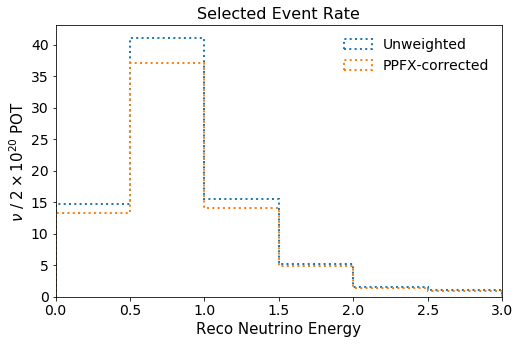

In [44]:
if isTruth == False:

    # ppfx correction effect 
    fig = plt.figure(figsize=(8, 5))

    plt.hist(selected_events[xvar], bins, range=[xlow, xhigh],
                weights=selected_events.pot_scale, linestyle=":", linewidth=2, histtype='step', 
                      label='Unweighted')

    plt.hist(selected_events[xvar], bins, range=[xlow, xhigh],
                weights=selected_events.totweight_data, linestyle=":", linewidth=2, histtype='step', 
                      label='PPFX-corrected')


    # plot format stuff
    plt.legend(loc='best', prop={"size":14}, ncol=1, frameon=False)

    plt.ylabel('$\\nu$ / $2\\times10^{20}$ POT', fontsize=15)

    plt.xlabel("Reco "+x_label, fontsize=15)
    plt.xticks(x_ticks, fontsize=14)

    plt.yticks(fontsize=14)

    plt.xlim(xlow, xhigh)
    plt.title("Selected Event Rate", fontsize=16)

    plt.show()



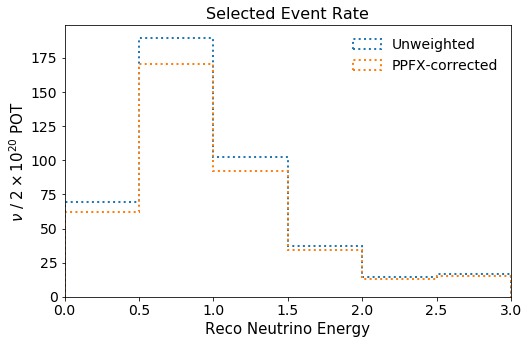

In [44]:
if isTruth == True:

    # ppfx correction effect 
    fig = plt.figure(figsize=(8, 5))

    plt.hist(selected_events.query('is_signal==True')[true_var], bins, range=[xlow, xhigh],
                weights=selected_events.query('is_signal==True').pot_scale, linestyle=":", linewidth=2, histtype='step', 
                      label='Unweighted')

    true_nuWro = plt.hist(selected_events.query('is_signal==True')[true_var], bins, range=[xlow, xhigh],
                weights=selected_events.query('is_signal==True').totweight_data, linestyle=":", linewidth=2, histtype='step', 
                      label='PPFX-corrected')


    # plot format stuff
    plt.legend(loc='best', prop={"size":14}, ncol=1, frameon=False)

    plt.ylabel('$\\nu$ / $2\\times10^{20}$ POT', fontsize=15)

    plt.xlabel("Reco "+x_label, fontsize=15)
    plt.xticks(x_ticks, fontsize=14)

    plt.yticks(fontsize=14)

    plt.xlim(xlow, xhigh)
    plt.title("Selected Event Rate", fontsize=16)

    plt.show()


In [45]:
if isTruth == True:
    print("True nuWro for comparison: ", true_nuWro[0])

    print(sum(true_nuWro[0]))

True nuWro for comparison:  [ 62.29377134 170.14500672  92.21299166  34.17399711  13.33827119
  15.57993508]
387.7439730913552


In [46]:
if isTruth == True:   
    ending = "Jan19b"
    
    np.savetxt("nue_nuWro_prior_true_run1_energy_"+ending+".csv", 
               true_nuWro[0],
               delimiter =", ", 
               fmt ='% s')

GENIE bkg subtractions

In [45]:
ending = "Jan19b"

In [46]:

nue_bkg_noExt = pd.read_csv("nue_nopions_recoE_usingSelection_run1_cv_nue_bkg_noExt_noDirt_"+ending+".csv", header=None)

print(nue_bkg_noExt.values[:, 0])
##########################

nue_evt_rate = pd.read_csv("nue_nopions_recoE_usingSelection_run1_cv_nue_evt_rate_"+ending+".csv", header=None)

nue_evt_rate = nue_evt_rate.values[:, 0]
print(nue_evt_rate)

#########################

nue_full_evt_rate = pd.read_csv("nue_full_500_catsel_nopions_recoE_usingSelection_prior_true_signal_recoCut_"+ending+".csv", header=None)

nue_full_evt_rate = nue_full_evt_rate.values[:, 0]
print(nue_full_evt_rate)

[4.60511863 9.45904503 4.30707752 1.99890035 0.51509894 0.61260431]
[ 7.54933089 28.90186196 11.869288    3.38853422  1.18822898  0.7600639 ]
[ 74.84183369 188.51387187 103.27864184  36.93153515  14.59539608
  16.55968061]


[13.27200403 37.07373718 14.05394212  4.82427243  1.44403517  0.98508674]


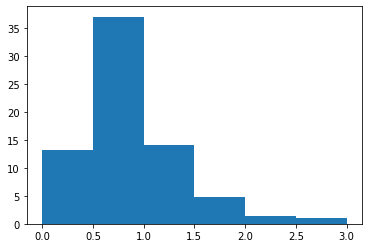

In [47]:


n, b, p = plt.hist(selected_events[xvar], bins, range=[xlow, xhigh],
            weights=selected_events.totweight_data)
#plt.close()

print(n)

In [48]:
len(n)

6

In [49]:
bincenters

array([0.25, 0.75, 1.25, 1.75, 2.25, 2.75])

In [50]:


binwidth = []

for x in range(len(bincenters)):
    
    if xvar=='tksh_angle': 
        binwidth.append(round(abs((x_ticks)[x+1]-(x_ticks)[x])/2, 2))
        
    else: 
        binwidth.append(round(abs((x_ticks+[xhigh])[x+1]-(x_ticks+[xhigh])[x])/2, 2))
    
binwidth



[0.25, 0.25, 0.25, 0.25, 0.25, 0.25]

In [51]:
## do not include EXT background subtraction! MC only 
#cv_bkgd_mc = [a-b for a,b in zip(fhc_dict['cv_bkgd'], fhc_dict['cv_ext'])]
#I already do not in what has been loaded in

cv_bkgd_mc = nue_bkg_noExt.values[:, 0]

In [52]:
cv_bkgd_mc

array([4.60511863, 9.45904503, 4.30707752, 1.99890035, 0.51509894,
       0.61260431])

In [53]:
# background subtracted event rate - EXT was never added so never subtracted
#(still need to take into acct its uncertainty)
nuwro_evt_rate = [a-b for a,b in zip(n,cv_bkgd_mc)]


In [54]:
len(nuwro_evt_rate)

6

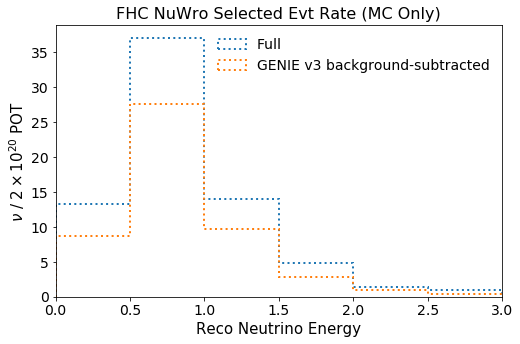

In [55]:
fig = plt.figure(figsize=(8, 5))

plt.hist(selected_events[xvar],
            bins, histtype='step', range=[xlow, xhigh],
            weights=selected_events.totweight_data, linestyle=":", linewidth=2, 
                  label='Full')

plt.hist(bincenters, bins, histtype='step', range=[xlow,xhigh], 
        weights=nuwro_evt_rate, linestyle=":", linewidth=2, 
                  label='GENIE v3 background-subtracted')

# plot format stuff
plt.legend(loc='best', prop={"size":14}, ncol=1, frameon=False)

plt.ylabel('$\\nu$ / $2\\times10^{20}$ POT', fontsize=15)
    
plt.xlabel("Reco "+x_label, fontsize=15)
plt.xticks(x_ticks, fontsize=14)

plt.yticks(fontsize=14)
#plt.ylim(0, 7)

plt.xlim(xlow, xhigh)
plt.title("FHC NuWro Selected Evt Rate (MC Only)", fontsize=16)

plt.show()


(array([13.27200403, 37.07373718, 14.05394212,  4.82427243,  1.44403517,
         0.98508674]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. ]),
 <a list of 1 Patch objects>)

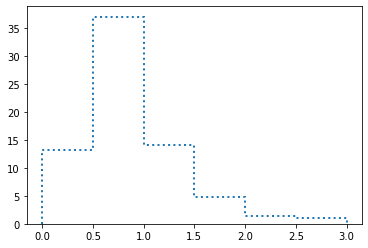

In [56]:
plt.hist(selected_events[xvar],
            bins, histtype='step', range=[xlow, xhigh],
            weights=selected_events.totweight_data, linestyle=":", linewidth=2, 
                  label='Full')

In [57]:
sum(nuwro_evt_rate)

50.15523288734895

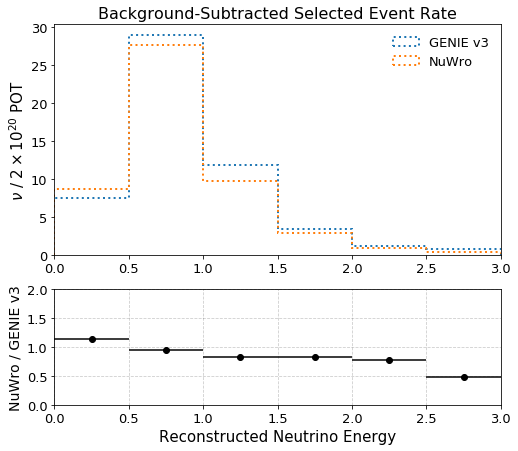

In [58]:
from matplotlib import gridspec

fig = plt.figure(figsize=(8, 7))

gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
    
ax1.tick_params(axis = 'both', which = 'major', labelsize = 13)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 13)

ax2.yaxis.grid(linestyle="--", color='black', alpha=0.2)
ax2.xaxis.grid(linestyle="--", color='black', alpha=0.2)

# background subtracted genie evt rate 
ax1.hist(bincenters, bins, histtype='step', range=[xlow,xhigh], 
        weights=nue_evt_rate, linestyle=":", linewidth=2, 
                  label='GENIE v3')

# background subtracted nuwro evt rate
ax1.hist(bincenters, bins, histtype='step', range=[xlow,xhigh], 
        weights=nuwro_evt_rate, linestyle=":", linewidth=2, 
                  label='NuWro')

# ratio plot  
ax2.errorbar(bincenters, [a/b for a,b in zip(nuwro_evt_rate, nue_evt_rate)], 
             xerr=binwidth, color="black", fmt='o')
ax2.set_ylim(0,2)


# plot formatting 
ax1.set_xlim(xlow,xhigh)
ax1.set_xticks(x_ticks)
ax1.set_ylabel('$\\nu$ / $2\\times10^{20}$ POT', fontsize=15)

ax2.set_xlim(xlow,xhigh)
ax2.set_xticks(x_ticks)

ax2.set_xlabel(x_label, fontsize=14)
ax2.set_ylabel("NuWro / GENIE v3", fontsize=14)

ax1.legend(fontsize=13, frameon=False)
    
ax2.set_xlabel("Reconstructed "+x_label, fontsize=15)
ax1.set_title("Background-Subtracted Selected Event Rate", fontsize=16)

#if ISRUN3=='': 
#    plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/combined_"+xvar+"_closuretest.pdf", 
#            transparent=True, bbox_inches='tight')

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/fhc/fakedata/nuwro_evt_rate_compare_"+xvar+".pdf", 
#            transparent=True, bbox_inches='tight')
plt.show()

In [59]:


# nuwro selected neutrino backgrounds
nuwro_bkgd = pd.concat([datasets_bdt['infv'].query('is_signal==False'), datasets_bdt['outfv']])



In [60]:
nuwro_evt_rate

[8.666885398366421,
 27.61469214895315,
 9.7468645925657,
 2.8253720797375443,
 0.9289362383954511,
 0.372482429330679]

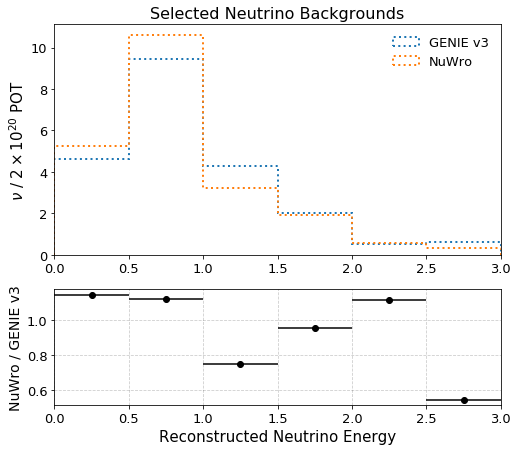

In [61]:
fig = plt.figure(figsize=(8, 7))

gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
    
ax1.tick_params(axis = 'both', which = 'major', labelsize = 13)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 13)

ax2.yaxis.grid(linestyle="--", color='black', alpha=0.2)
ax2.xaxis.grid(linestyle="--", color='black', alpha=0.2)

# genie
ax1.hist(bincenters, bins, histtype='step', range=[xlow,xhigh], 
        weights=cv_bkgd_mc, linestyle=":", linewidth=2, 
                  label='GENIE v3')

# background subtracted nuwro evt rate
h_nuwro_bkgd = ax1.hist(nuwro_bkgd[xvar], bins, histtype='step', 
                        weights=nuwro_bkgd.totweight_data, range=[xlow,xhigh], 
         linestyle=":", linewidth=2, 
                  label='NuWro')[0]

# ratio plot  
ax2.errorbar(bincenters, [a/b for a,b in zip(h_nuwro_bkgd, cv_bkgd_mc)], 
             xerr=binwidth, color="black", fmt='o')
#ax2.set_ylim(0, 2)

#ax1.set_ylim(0, 5)


# plot formatting 
ax1.set_xlim(xlow,xhigh)
ax1.set_xticks(x_ticks)
ax1.set_ylabel('$\\nu$ / $2\\times10^{20}$ POT', fontsize=15)

ax2.set_xlim(xlow,xhigh)
ax2.set_xticks(x_ticks)

ax2.set_xlabel(x_label, fontsize=14)
ax2.set_ylabel("NuWro / GENIE v3", fontsize=14)

ax1.legend(fontsize=13, frameon=False)
    
ax2.set_xlabel("Reconstructed "+x_label, fontsize=15)
ax1.set_title("Selected Neutrino Backgrounds", fontsize=16)


#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/fhc/fakedata/nuwro_mc_bkgd_compare_"+xvar+".pdf", 
#            transparent=True, bbox_inches='tight')

plt.show()

In [62]:
#This should be prior true signal from genie
#genie_true = generated_signal(False, true_var, bins, xlow, xhigh)[0]

genie_true = nue_full_evt_rate

print(genie_true)

[ 74.84183369 188.51387187 103.27864184  36.93153515  14.59539608
  16.55968061]


[0.25 0.75 1.25 1.75 2.25 2.75]


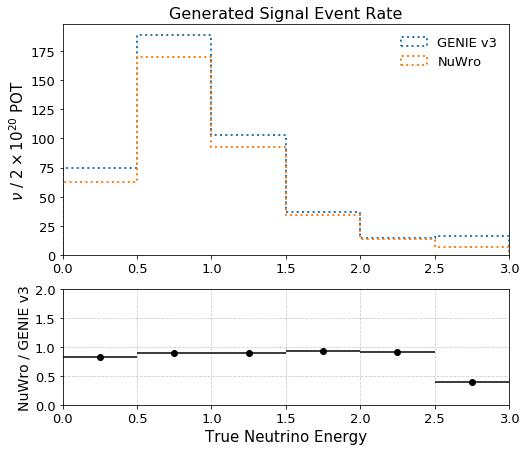

In [63]:
fig = plt.figure(figsize=(8, 7))

gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
    
ax1.tick_params(axis = 'both', which = 'major', labelsize = 13)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 13)

ax2.yaxis.grid(linestyle="--", color='black', alpha=0.2)
ax2.xaxis.grid(linestyle="--", color='black', alpha=0.2)

ax1.hist(bincenters, bins, histtype='step', range=[xlow,xhigh], 
        weights=genie_true, linestyle=":", linewidth=2, 
                  label='GENIE v3')

print(bincenters)

nuwro_true = ax1.hist(generated_events.query('is_signal==True')[true_var], bins, 
                      histtype='step', range=[xlow,xhigh], 
                      weights=generated_events.query('is_signal==True')['totweight_data'], 
                      linestyle=":", linewidth=2, 
                  label='NuWro')[0]


# ratio plot  
ax2.errorbar(bincenters, [a/b for a,b in zip(nuwro_true, genie_true)], 
             xerr=binwidth, color="black", fmt='o')
ax2.set_ylim(0, 2)


# plot formatting 
ax1.set_xlim(xlow,xhigh)
ax1.set_xticks(x_ticks)
ax1.set_ylabel('$\\nu$ / $2\\times10^{20}$ POT', fontsize=15)

ax2.set_xlim(xlow,xhigh)
ax2.set_xticks(x_ticks)

ax2.set_xlabel(x_label, fontsize=14)
ax2.set_ylabel("NuWro / GENIE v3", fontsize=14)

ax1.legend(fontsize=13, frameon=False)
    
ax2.set_xlabel("True "+x_label, fontsize=15)
ax1.set_title("Generated Signal Event Rate", fontsize=16)

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/fhc/fakedata/nuwro_gen_signal_compare_"+xvar+".pdf", 
#            transparent=True, bbox_inches='tight')
plt.show()

Generated (True - GENIE v3) =  [ 74.84183369 188.51387187 103.27864184  36.93153515  14.59539608
  16.55968061]
Selected (Reco - NuWro) =  [8.666885398366421, 27.61469214895315, 9.7468645925657, 2.8253720797375443, 0.9289362383954511, 0.372482429330679]


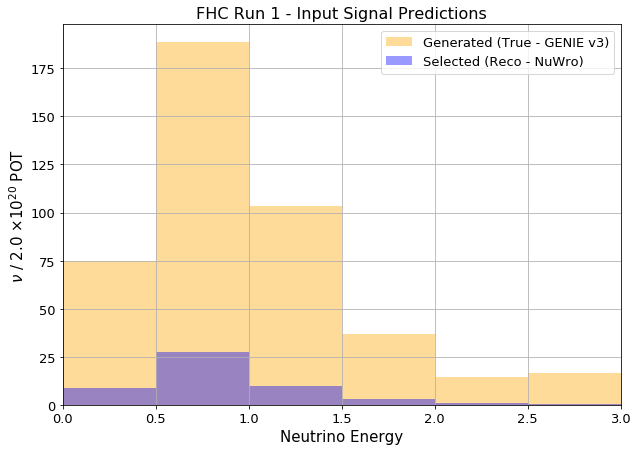

In [64]:
# nuwro input distributions 

fig = plt.figure(figsize=(10, 7))

#So this is Prior True
plt.hist(bincenters, bins, color='orange', label='Generated (True - GENIE v3)', alpha=0.4, 
         weights=genie_true)

print("Generated (True - GENIE v3) = ", genie_true)


#Anf this is Data Signal
# genie background subtracted evt rate 
plt.hist(bincenters, bins, color='blue', label='Selected (Reco - NuWro)', alpha=0.4, weights=nuwro_evt_rate)

print('Selected (Reco - NuWro) = ', nuwro_evt_rate)

plt.legend(fontsize=13)
plt.title('FHC Run 1 - Input Signal Predictions', fontsize=16)

plt.xlim(xlow, xhigh)

plt.xlabel(x_label, fontsize=15)
    
plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.ylabel("$\\nu$ / 2.0 $\\times 10^{20}$ POT", fontsize=15)

plt.grid()

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/fhc/fakedata/nuwro_input_dist_"+xvar+".pdf", 
#            transparent=True, bbox_inches='tight')

plt.show()

In [65]:
nuwro_evt_rate

[8.666885398366421,
 27.61469214895315,
 9.7468645925657,
 2.8253720797375443,
 0.9289362383954511,
 0.372482429330679]

In [66]:
# sumw2 of the full event rate 
nuwro_full_sumw2 = []

for i in range(len(bins)-1):

    if i==len(bins)-2: 
        bin_query = xvar+' >= '+str(bins[i])+' and '+xvar+' <= '+str(bins[i+1])
    else: 
        bin_query = xvar+' >= '+str(bins[i])+' and '+xvar+' < '+str(bins[i+1])

    #nuwro_full_sumw2.append(sum(datasets_bdt['infv'].query('is_signal==True and '+bin_query).totweight_data ** 2) ) #bug (fixed below)
    nuwro_full_sumw2.append(sum(selected_events.query(bin_query).totweight_data ** 2))
    
    
# percent stat error - of the background subtracted event rate 
#print( [(np.sqrt(a)/b) for a,b in zip(nuwro_full_sumw2, nuwro_evt_rate)] )
print(nuwro_full_sumw2)

[1.2770149331764253, 2.318316357544687, 0.4460135305493301, 0.2910667080163794, 0.09605893031603151, 0.011174284191419059]


In [67]:
nuwro_full_sumw2

[1.2770149331764253,
 2.318316357544687,
 0.4460135305493301,
 0.2910667080163794,
 0.09605893031603151,
 0.011174284191419059]

Signal Region Systematic - NuWro

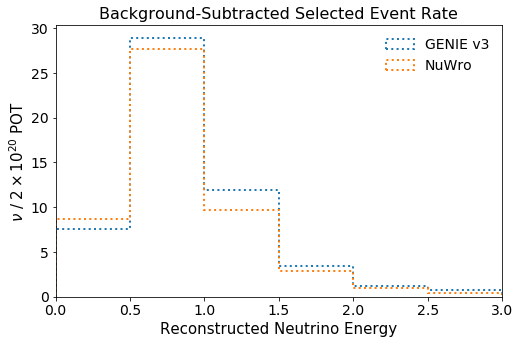

In [68]:
# genie vs nuwro event rate

fig = plt.figure(figsize=(8, 5))

# background subtracted genie evt rate 
plt.hist(bincenters, bins, histtype='step', range=[xlow,xhigh], 
        weights=nue_evt_rate, linestyle=":", linewidth=2, 
                  label='GENIE v3')

# background subtracted nuwro evt rate
plt.hist(bincenters, bins, histtype='step', range=[xlow,xhigh], 
        weights=nuwro_evt_rate, linestyle=":", linewidth=2, 
                  label='NuWro')

# plot format stuff
plt.legend(loc='best', prop={"size":14}, ncol=1, frameon=False)

plt.ylabel('$\\nu$ / $2\\times10^{20}$ POT', fontsize=15)
    
plt.xlabel("Reconstructed "+x_label, fontsize=15)
plt.xticks(x_ticks, fontsize=14)

plt.yticks(fontsize=14)

plt.xlim(xlow, xhigh)


plt.title("Background-Subtracted Selected Event Rate", fontsize=16)

plt.show()

In [69]:
# genie_evt_rate - background subtracted event rate 
# nuwro_evt_rate - background subtracted event rate 
# genie_nu_bkgd - neutrino background prediction from genie 
# nuwro_nu_bkgd - neutrino background prediction from nuwro

sys_dict = {}



In [70]:
sys_dict['genie_evt_rate'] = nue_evt_rate
sys_dict['nuwro_evt_rate'] = nuwro_evt_rate
sys_dict['genie_nu_bkgd'] = cv_bkgd_mc
sys_dict['nuwro_nu_bkgd'] = list(h_nuwro_bkgd)


In [71]:
np.savetxt("nue_nuWro_MC_Data_Signal_recoCut_run1_energy_"+ending+".csv", 
           nuwro_evt_rate,
           delimiter =", ", 
           fmt ='% s')

In [72]:
nuwro_true

array([ 62.29377134, 170.14500672,  92.21299166,  34.17399711,
        13.33827119,   6.63857479])

In [73]:
genie_true

array([ 74.84183369, 188.51387187, 103.27864184,  36.93153515,
        14.59539608,  16.55968061])

## Create the Nue Cov Uncertainty Matrix

- NuWro Stat Errs
- MC background stat errs
- genie systematics

In [74]:
#nuWro_stat_err_nue
#array([0.00324513, 0.00761901, 0.01058196, 0.01693113, 0.02469124,
#       0.03358008, 0.04952356, 0.08648987, 0.14927616, 0.32507775])

nuWro_stat_err_nue = nuwro_full_sumw2
print(nuWro_stat_err_nue)

[1.2770149331764253, 2.318316357544687, 0.4460135305493301, 0.2910667080163794, 0.09605893031603151, 0.011174284191419059]


In [75]:
nue_bkg_genie_err = pd.read_csv("nue_bkg_exp_err_squared_energy_"+ending+".csv", header=None)

nue_bkg_genie_err = nue_bkg_genie_err.values[:, 0]
print(nue_bkg_genie_err)

[0.94338064 1.11191896 0.188835   0.0869369  0.0068366  0.02543739]


In [76]:
totalstat_nue_err = nuWro_stat_err_nue + nue_bkg_genie_err
print(totalstat_nue_err)

np.savetxt("totalstat_nuWro_nue_err_energy_"+ending+".csv", 
               totalstat_nue_err,
               delimiter =", ", 
               fmt ='% s')

[2.22039558 3.43023532 0.63484853 0.37800361 0.10289553 0.03661167]


In [77]:
nue_cov_stats   = np.zeros([(len(bins)-1), (len(bins)-1)])
print(nue_cov_stats)

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


In [78]:
nue_cov_stats[np.diag_indices_from(nue_cov_stats)]    = totalstat_nue_err

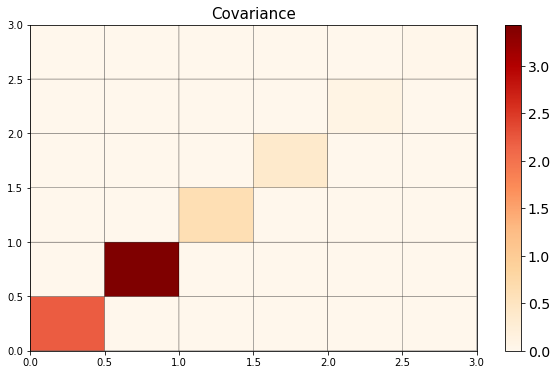

In [79]:
fig = plt.figure(figsize=(10, 6))
        
plt.pcolor(bins, bins, nue_cov_stats, cmap='OrRd', edgecolors='k')#, vmin=-1, vmax=1)
            
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)




#plt.xlabel('Reco Shower Energy [GeV]', fontsize=15)
#plt.ylabel('Reco Shower Energy [GeV]', fontsize=15)

plt.title('Covariance', fontsize=15)

plt.show()

In [81]:
# Now need to load in the genie sys errs from nue

nue_bkg_genie_err = pd.read_csv("nue_cov_genie_only_energy_"+ending+".csv", header=None)

nue_bkg_genie_err = nue_bkg_genie_err.values
print(nue_bkg_genie_err)

[[ 2.6919917  10.09510414  4.32769306  1.54275592  0.44957541  0.34308106]
 [10.09510414 43.82623193 19.26349025  6.82178965  2.00662245  1.50526308]
 [ 4.32769306 19.26349025  8.653185    3.03068541  0.89851515  0.67758497]
 [ 1.54275592  6.82178965  3.03068541  1.10532154  0.31386409  0.23516276]
 [ 0.44957541  2.00662245  0.89851515  0.31386409  0.09898215  0.07016739]
 [ 0.34308106  1.50526308  0.67758497  0.23516276  0.07016739  0.0567736 ]]


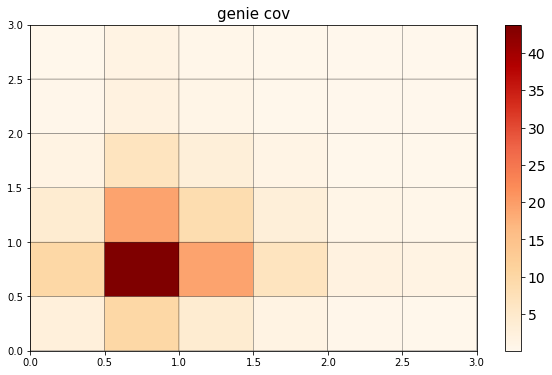

In [82]:
fig = plt.figure(figsize=(10, 6))
        
plt.pcolor(bins, bins, nue_bkg_genie_err, cmap='OrRd', edgecolors='k')#, vmin=-1, vmax=1)
            
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)




#plt.xlabel('Reco Shower Energy [GeV]', fontsize=15)
#plt.ylabel('Reco Shower Energy [GeV]', fontsize=15)

plt.title('genie cov', fontsize=15)

plt.show()

In [83]:
total_cov_nuWro_nue = nue_bkg_genie_err + nue_cov_stats

In [84]:
np.savetxt("data_covmat_nue_MC_nuWro_input_recoE_"+ending+".csv", 
           total_cov_nuWro_nue,
           delimiter =", ", 
           fmt ='% s')

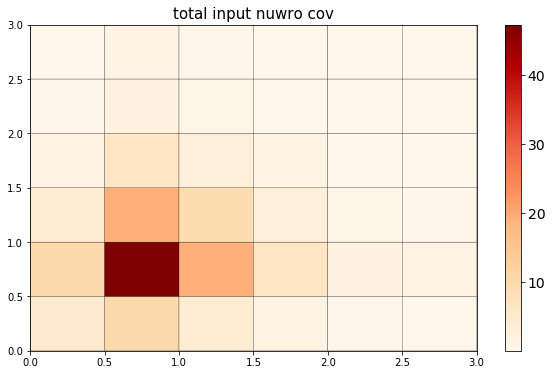

In [85]:
fig = plt.figure(figsize=(10, 6))
        
plt.pcolor(bins, bins, total_cov_nuWro_nue, cmap='OrRd', edgecolors='k')#, vmin=-1, vmax=1)
            
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)




#plt.xlabel('Reco Shower Energy [GeV]', fontsize=15)
#plt.ylabel('Reco Shower Energy [GeV]', fontsize=15)

plt.title('total input nuwro cov', fontsize=15)

plt.show()

In [86]:
np.savetxt("nue_total_cov_nuWro_energy_"+ending+".csv", 
       total_cov_nuWro_nue,
       delimiter =", ", 
       fmt ='% s')  

In [87]:
total_cor_nuWro_nue = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
for i in range(len(total_cov_nuWro_nue)): 
        for j in range(len(total_cov_nuWro_nue[i])): 

            if np.sqrt(total_cov_nuWro_nue[i][i])*np.sqrt(total_cov_nuWro_nue[j][j]) != 0: 
                total_cor_nuWro_nue[i][j] = total_cov_nuWro_nue[i][j] / (np.sqrt(total_cov_nuWro_nue[i][i])*np.sqrt(total_cov_nuWro_nue[j][j]))
                
print("")
print(total_cor_nuWro_nue)


[[1.0000000000000002, 0.6625732204230819, 0.640690471705235, 0.5715217231675723, 0.4514525373578658, 0.5065370991930345], [0.6625732204230819, 1.0, 0.9194803751200132, 0.814797181748251, 0.6496671142582933, 0.7165435531465543], [0.640690471705235, 0.9194803751200132, 1.0, 0.8165086533720357, 0.6561745143595413, 0.727549730837359], [0.5715217231675723, 0.814797181748251, 0.8165086533720357, 1.0000000000000002, 0.5735605742214354, 0.6318459216023917], [0.4514525373578658, 0.6496671142582933, 0.6561745143595413, 0.5735605742214354, 1.0, 0.511036548823704], [0.5065370991930345, 0.7165435531465543, 0.727549730837359, 0.6318459216023917, 0.511036548823704, 1.0000000000000002]]


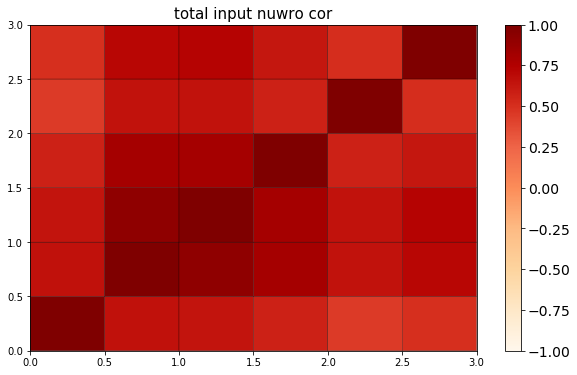

In [88]:
fig = plt.figure(figsize=(10, 6))
        
plt.pcolor(bins, bins, total_cor_nuWro_nue, cmap='OrRd', edgecolors='k', vmin=-1, vmax=1)#, vmin=-1, vmax=1)
            
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)




#plt.xlabel('Reco Shower Energy [GeV]', fontsize=15)
#plt.ylabel('Reco Shower Energy [GeV]', fontsize=15)

plt.title('total input nuwro cor', fontsize=15)

plt.show()

In [89]:
total_frac_cov_nuWro_nue = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]

for i in range(len(bins)-1): 

    for j in range(len(bins)-1): 

        c = total_cov_nuWro_nue[i][j]
        
        if nuWro_selected_events_nue[i]*nuWro_selected_events_nue[j] != 0:
            total_frac_cov_nuWro_nue[i][j] = c/(nuWro_selected_events_nue[i]*nuWro_selected_events_nue[j])

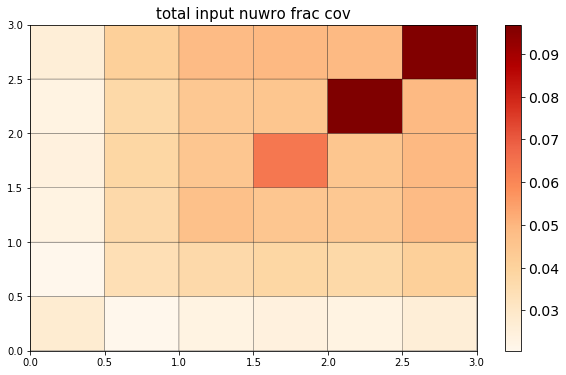

In [90]:
fig = plt.figure(figsize=(10, 6))
        
plt.pcolor(bins, bins, total_frac_cov_nuWro_nue, cmap='OrRd', edgecolors='k')#, vmin=-1, vmax=1)
            
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)




#plt.xlabel('Reco Shower Energy [GeV]', fontsize=15)
#plt.ylabel('Reco Shower Energy [GeV]', fontsize=15)

plt.title('total input nuwro frac cov', fontsize=15)

plt.show()